In [1]:
import numpy as np
import pydot
from IPython.display import HTML, SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    GenerateHtml,
    InverseDynamicsController,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
)

from manipulation import running_as_notebook

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7005


# Simulation with block diagrams

In this chapter, and throughout the notes, we will be building up our simulations and controllers using drake's block diagram modeling language (we call it the "systems framework").  [This tutorial](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/%2Fdynamical_systems.ipynb)  provides a brief introduction.  


# Simulating the (passive) panda

Let's load our robot of choice (the Kuka panda) into the physics engine, which we call [MultibodyPlant](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html).


In [3]:
plant = MultibodyPlant(time_step=1e-4)
Parser(plant).AddModelsFromUrl(
    "package://drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"
)
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

In Drake, we are very careful to separate the *state* of a system from the system itself.  For example, let's think of a dynamical system as given by the difference equation: $$x[n+1] = f(n, x[n], u[n]),$$ where $n$ is the "time", $x$ is the state, and $u$ is any inputs to the system.  The `System` describes $f()$, but we use a structure called the [`Context`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_context.html) to hold the runtime values: $n, x, u$.  We use a structure, because some systems have even more runtime values, that describe system parameters, random noise inputs, etc, and it is cleaner to pass a structure around than have each system accept a different list of possible inputs.  As a rule `System` is constant over the duration of a simulation, and you should be able to obtain repeatable, deterministic simulations given any value `Context`.

Let's see what the `Context` looks like for the physics engine now that we've loaded the panda into it.

In [4]:
context = plant.CreateDefaultContext()
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     18 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  42 numeric parameter groups with
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
                        2.92             -0.025566             -2.88e-05              0.057332  0.005965826910737946  0.007674413231130136   0.004

The system has 14 state variables -- these are the 7 joint positions and 7 joint velocities for the panda.  Those states are discrete, because we passed a non-zero `time_step` to the constructor of the `MultibodyPlant`, which means the physics engine will be use a time-stepping simulation scheme (this will be the most performant when we start simulating contact).  Go ahead and try changing `time_step` to zero, and see what happens.

You'll notice the context has lots of parameters (currently these include the mass, the center of mass, and the inertia of each body).  You won't need those any time soon, but it does enable some super cool advanced features.

Because the `Context` for a `MultibodyPlant` can get quite complicated, `MultibodyPlant` offers some methods that help you get/set the values.  Let's set some non-zero initial positions.

In [5]:
# Set all of the joint positions at once in a single vector.
plant.SetPositions(context, [-1.57, 0.1, 0, 0, 0, 1.6, 0, 0, 0])
# You can also set them by referencing particular joints.
plant.GetJointByName("panda_joint4").set_angle(context, -1.2)
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     18 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0     0     0     0     0

Parameters:
  42 numeric parameter groups with
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
                        2.92             -0.025566             -2.88e-05  

The panda model also defined 7 actuators.  Before we can run a simulation, we need to provide some values for those inputs to the `MultibodyPlant` `actuation_input_port`.  For this warm-up, we'll just set them to zero.

In [6]:
plant.get_actuation_input_port().FixValue(context, np.zeros(9))

Now we can set up and run a simulation.

In [7]:
simulator = Simulator(plant, context)
simulator.AdvanceTo(5.0)
print(context)

::_ Context
------------
Time: 5
States:
  1 discrete state groups with
     18 states
          -0.3923862904491683      1.763797117875747    -0.5072603268910875     -1.291600568836684      2.756547878842867      3.093899116846915     -1.846483600727128    0.04000177749335408 -1.772337407959474e-06     0.1990340703688434  0.0006666003209566673      1.010180387427854     -1.679839779172553    -0.1322236356905677      1.400554792788378     0.3120166995321272  2.642128054063438e-07 -1.547728553149336e-07

Parameters:
  42 numeric parameter groups with
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.055

# Visualizing the scene

The best way to visualize the results of a physics engine is with a 2D or 3D visualizer. For that, we need to add the system which curates the geometry of a scene (the geometry engine); in Drake with call it the [`SceneGraph`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_scene_graph.html). Once we have a `SceneGraph`, then there are a number of different visualizers and sensors that we can add to the system to actually render the scene.

We support a number of visualizers in drake (we ship a simple VTK-based "drake-visualizer" with our binary releases, or you can use RViz).  But because we're working in a jupyter notebook, and want you to be able to run 3D graphics on any machine without any installation required, we'll use the [MeshCat](https://github.com/rdeits/meshcat) visualizer throughout these notes.  

To use all three systems (`MultibodyPlant`, `SceneGraph`, and `MeshcatVisualizer`), we need to assemble them into a [`Diagram`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram.html) using a [`DiagramBuilder`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram_builder.html).  Often you would add each system and then connect the ports together, but for common cases like we have here, we provide helper methods to reduce the boilerplate.

In [8]:
meshcat.Delete()
meshcat.DeleteAddedControls()
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelsFromUrl(
    "package://drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"
)
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("plant and scene_graph")

If you click on the link above, you can open a browser window to see the visualization.

But the scene will be empty so far.  We need to actually construct the diagram and ask it to publish.  (You normally don't have to call these; MeshcatVisualizer will automatically load at initialization and publish on a fixed period during simulation).

In [9]:
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)

We've put together quite a complex system now.  A `Diagram` is just another `System`, so it has an associated context.

In [10]:
print(context)

::plant and scene_graph Context (of a Diagram)
-----------------------------------------------
18 total discrete states in 1 groups
280 total numeric parameters in 42 groups
14 total abstract parameters

::plant and scene_graph::plant Context
---------------------------------------
Time: 0
States:
  1 discrete state groups with
     18 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  42 numeric parameter groups with
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0


It's also very useful to draw the actual block diagram.

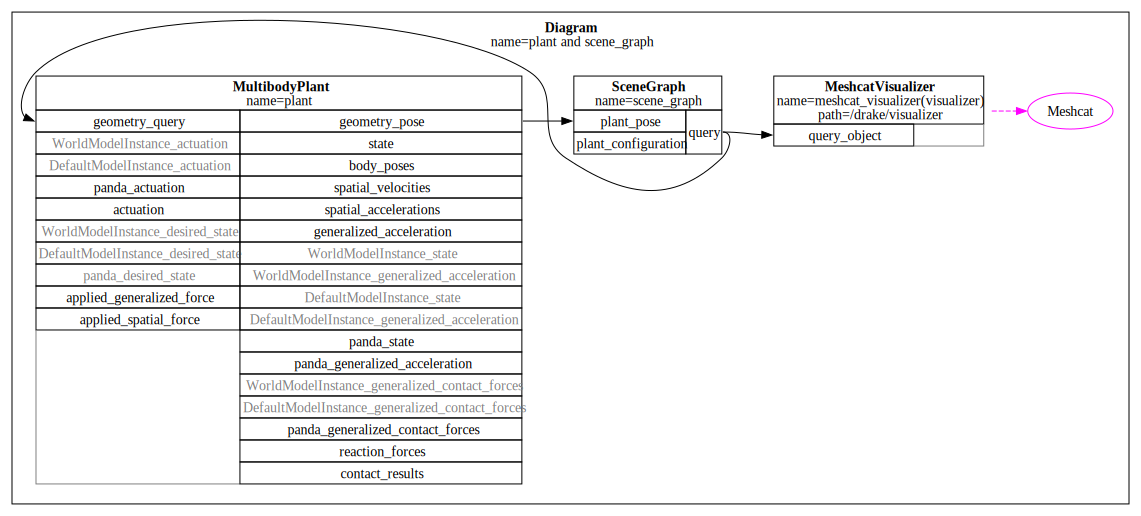

In [11]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

There is one more important detail: **The `Context` for the `Diagram` is not the `Context` of the `MultibodyPlant`.  But you can extract the plant `Context`; and we need to in order to set the initial conditions of the robot.

In [12]:
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0, 0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(9))
print(context)

::plant and scene_graph Context (of a Diagram)
-----------------------------------------------
18 total discrete states in 1 groups
280 total numeric parameters in 42 groups
14 total abstract parameters

::plant and scene_graph::plant Context
---------------------------------------
Time: 0
States:
  1 discrete state groups with
     18 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0     0     0     0     0

Parameters:
  42 numeric parameter groups with
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 pa

Accidentally using `context` instead of `plant_context` is a very common mistake!

Ok, now we're ready to simulate.  Make sure your visualizer window is visible, then run the following cell.

In [13]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)

Glorious!

Here's one more trick.  You can ask MeshCat to record the animation, and then review it in the visualizer using the sliders in the controls dialog.  

I'll repeat the preamble here to make this cell stand-alone.  (Plus we cannot reuse a system in multiple diagrams; the ownership is restricted).

In [14]:
def animation_demo():
    builder = DiagramBuilder()

    # Adds both MultibodyPlant and the SceneGraph, and wires them together.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # Note that we parse into both the plant and the scene_graph here.
    Parser(plant, scene_graph).AddModelsFromUrl(
        "package://drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"
    )
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
    plant.Finalize()

    # Adds the MeshcatVisualizer and wires it to the SceneGraph.
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0, 0])
    plant.get_actuation_input_port().FixValue(plant_context, np.zeros(9))

    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)

    meshcat.StartRecording()
    simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)
    meshcat.StopRecording()
    meshcat.PublishRecording()


animation_demo()

# Adding the panda controller

The panda hardware interface runs through a control system provided by the manufacturer.  We can't turn it off.  The best we can do is add our approximation of it to our simulation.  I'll repeat everything we've set up before (to keep this example self-contained), but we'll add one more system for the controller.

In [15]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
panda_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "package://drake/manipulation/models/franka_description/urdf/panda_arm_hand.urdf"
)[0]
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

# Adds an approximation of the panda controller.
# TODO(russt): replace this with the joint impedance controller.
kp = [100] * plant.num_positions()
ki = [1] * plant.num_positions()
kd = [20] * plant.num_positions()
panda_controller = builder.AddSystem(
    InverseDynamicsController(plant, kp, ki, kd, False)
)
panda_controller.set_name("panda_controller")
builder.Connect(
    plant.get_state_output_port(panda_model),
    panda_controller.get_input_port_estimated_state(),
)
builder.Connect(
    panda_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()
diagram.set_name("with panda controller")

Let's see what our diagram looks like...

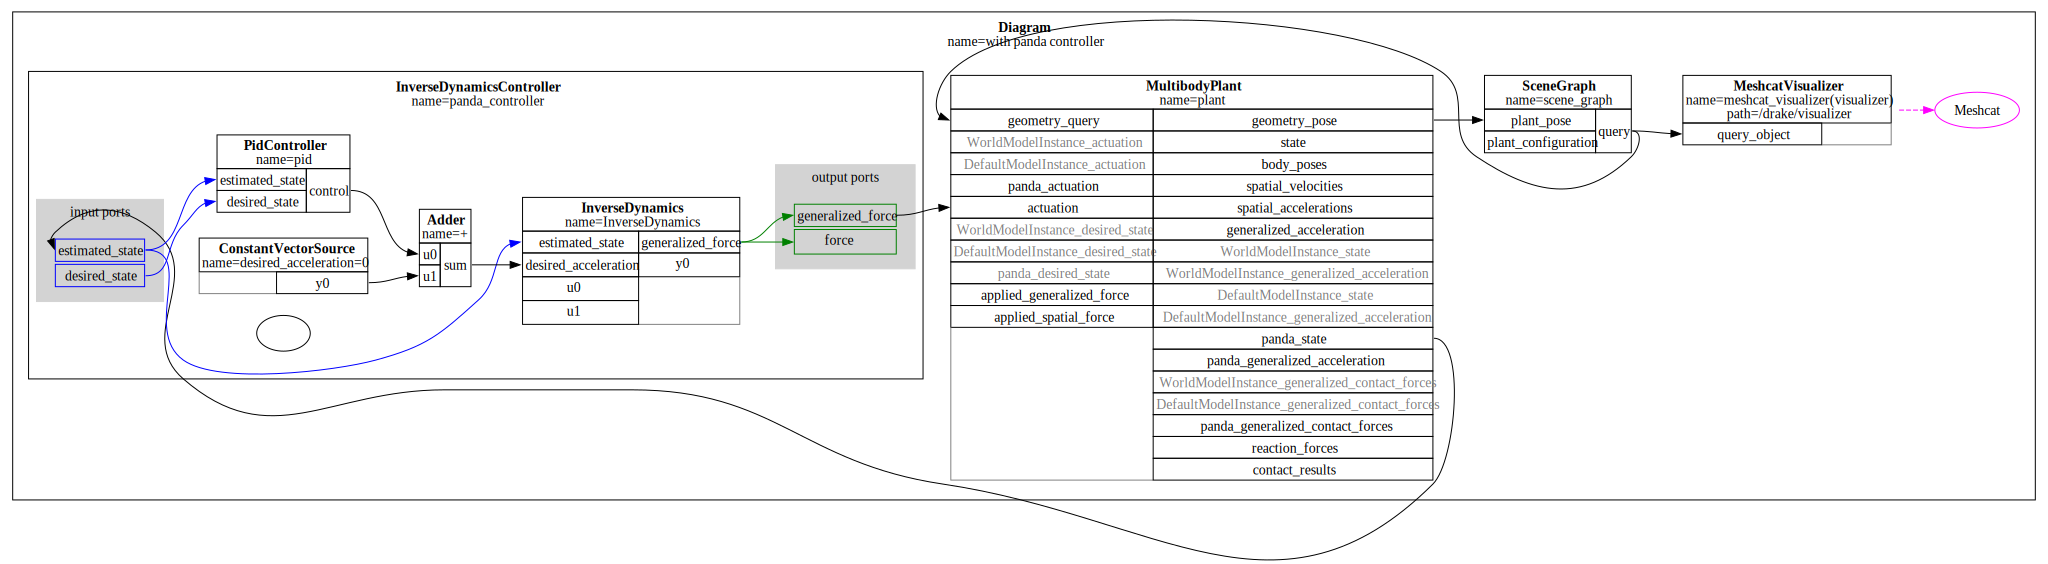

In [16]:
display(
    SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())
)

As our diagrams get more complex, you might pass the `max_depth` argument to the `GetGraphvizString` method.

TODO(russt): Update to javascript rendering [#13874](https://github.com/RobotLocomotion/drake/issues/13874). 

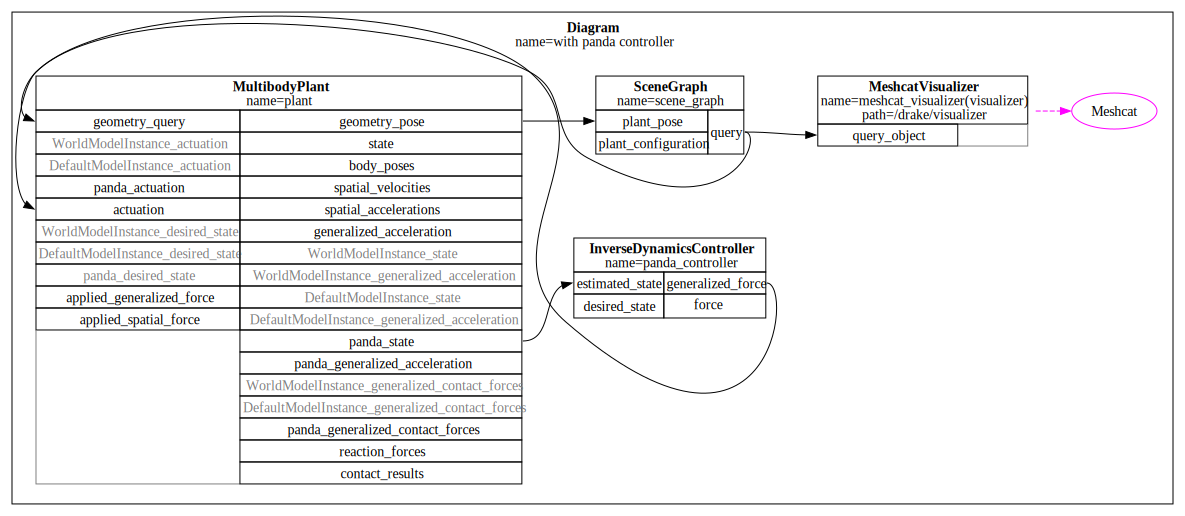

In [17]:
display(
    SVG(
        pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

To set up the `Context` now, instead of setting the `actuation_input` to zero, we set the `desired_state` of the panda controller to be the current position of the arm.  But the desired *state* must also include desired velocities, so we set those to zero.

In [18]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0, 0, 0])
x0 = np.hstack((q0, 0 * q0))
plant.SetPositions(plant_context, q0)
panda_controller.GetInputPort("desired_state").FixValue(
    panda_controller.GetMyMutableContextFromRoot(context), x0
)
print(context)

::with panda controller Context (of a Diagram)
-----------------------------------------------
9 total continuous states
18 total discrete states in 1 groups
289 total numeric parameters in 43 groups
14 total abstract parameters

::with panda controller::plant Context
---------------------------------------
Time: 0
States:
  1 discrete state groups with
     18 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0     0     0     0     0

Parameters:
  42 numeric parameter groups with
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       6.05721456e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       4.62474144e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 parameters
       100
     1 parameters
       2.05544064e-05
     1 param

Now, if we simulate, the robot just stays put.  Just like the real robot would.

In [19]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f86172b-b597-4ceb-9bad-92d11ac7a6cc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>